In [39]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
from datetime import datetime
import pandas as pd
import psycopg2
import configparser
import datetime
import nbimporter
from Connection_to_pgAdmin4 import *
from SQL import *

In [40]:

# Function to execute SQL queries
#SQL REFERENCE A


def execute_sql_query(query, params=None):
    
    # Establish a connection to the database
    connection = connect_to_database()

    try:
        if connection:
            cursor = connection.cursor()
            
            # Execute the SQL query
            if params:
                cursor.execute(query, params)
            else:
                cursor.execute(query)

            # If it's a SELECT query, fetch the results
            if query.strip().lower().startswith("select"):
                results = cursor.fetchall()
                cursor.close()
                return results

            # For other types of queries, commit the changes
            else:
                connection.commit()
               # print("Query executed successfully.")

    except (Exception, psycopg2.Error) as error:
        print(f"Error: {error}")
        if connection:
            connection.rollback()

    finally:
        if connection:
            connection.close()


In [41]:
# Function to fetch financial information for the last 3 months from the database.
def fetch_financial_info():
    # SQL query to select data from the last 5 months, ordered by Date and Symbol.
    query = """
    SELECT Date, Symbol, Open, High, Low, Close, Volume
    FROM dimension.d_financial_info
    WHERE Date > CURRENT_DATE - INTERVAL '5 months'
    ORDER BY Date DESC, Symbol
    """
    
    # Execute the SQL query and store the result.
    financial_data = execute_sql_query(query)
    
    # Check if the query returned any data.
    if financial_data:
        # Define column names for the pandas DataFrame.
        columns = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create a pandas DataFrame with the financial data.
        df = pd.DataFrame(financial_data, columns=columns)
        
        # Print the count of NaN values in each column.
        print(df.isnull().sum())  
        
        # Fill NaN values with zero. Alternative handling could be to use the mean.
        df.fillna(0, inplace=True)
        
        # Return the DataFrame with financial data.
        return df
    else:
        # Return None if no data was found.
        return None



In [79]:
test = fetch_financial_info()
print(test)

Date       0
Symbol     0
Open      62
High      62
Low       62
Close     62
Volume     0
dtype: int64
              Date  Symbol     Open     High      Low    Close      Volume
0       2024-03-15  0A0B.L  7237.00  7237.00  7233.21  7233.21     3605.00
1       2024-03-15  0A0C.L    29.02    29.02    27.98    28.18     2419.00
2       2024-03-15  0A1H.L    21.22    21.22    21.20    21.20        6.00
3       2024-03-15  0A1U.L    77.07    77.79    76.18    76.65    50279.00
4       2024-03-15  0A2K.L    15.42    15.42    15.40    15.42       75.00
...            ...     ...      ...      ...      ...      ...         ...
464274  2023-10-19  ZNWD.L     8.35     8.64     8.20     8.50   208827.00
464275  2023-10-19   ZOO.L    39.50    40.00    39.00    39.60   246362.00
464276  2023-10-19  ZPHR.L     3.25     3.39     3.16     3.25  2636229.00
464277  2023-10-19   ZTF.L   298.85   299.50   298.85   299.00     1075.00
464278  2023-10-19   ZYT.L    77.50    82.00    77.12    77.50    19415

In [43]:
# Function to preprocess financial data along with symbols and dates for LSTM model input.
# Window Size 30
def preprocess_data_with_symbols(df, seq_length=30):
    # Initialise a MinMaxScaler to scale features between 0 and 1.
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Get unique symbols from the DataFrame.
    symbols = df['Symbol'].unique()
    
    # Lists to store processed sequences, their corresponding symbols, and dates.
    processed_data = []
    sequence_symbols = []  # Keeps track of symbols for each processed sequence.
    sequence_dates = []  # Keeps track of the date for the last data point in each sequence.
    
    # Iterate over each symbol to process data symbol-wise.
    for symbol in symbols:
        # Create a copy of the DataFrame filtered by current symbol and sort it by date.
        data_symbol = df[df['Symbol'] == symbol].copy()
        data_symbol.sort_values(by='Date', inplace=True)
        
        # Scale the features (Open, High, Low, Close, Volume) for the current symbol.
        scaled_features = scaler.fit_transform(data_symbol[['Open', 'High', 'Low', 'Close', 'Volume']])
        
        # Generate sequences of length 'seq_length' for LSTM input.
        for i in range(len(scaled_features) - seq_length):
            # Each sequence contains 'seq_length' consecutive days of data.
            seq = scaled_features[i:i + seq_length + 1]
            processed_data.append(seq)
            sequence_symbols.append(symbol)  # Associate the current symbol with the sequence.
            # Associate the date of the last data point in the sequence.
            sequence_dates.append(data_symbol.iloc[i + seq_length - 1]['Date'])
            
    # Return the processed sequences, scaler, symbols, and dates as a tuple.
    return np.array(processed_data), scaler, sequence_symbols, sequence_dates



In [44]:
# Defines a function to build an LSTM model with a specified input shape.

def build_model(input_shape):
    # Initialises a Sequential model.
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),  # First LSTM layer with 50 units, returns sequences for further layers.
        LSTM(50),  # Second LSTM layer with 50 units.
        Dense(5)  # Dense layer with 5 units for output, matching the number of predicted features.
    ])
    
    # Compiles the model with the Adam optimizer and mean squared error loss function.
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    # Returns the compiled model.
    return model


In [45]:
# Main function to execute the model pipeline.
def main():
    # Fetch financial information from the database for the last 3 months.
    df = fetch_financial_info()
    
    # Check if the DataFrame is not empty.
    if df is not None:
        # Preprocess the data to prepare sequences for LSTM model training.
        
        # This includes scaling of features and associating symbols and dates with each sequence.
        processed_data, scaler, sequence_symbols, sequence_dates = preprocess_data_with_symbols(df)
        
        # Shuffle the sequences to randomize the order before splitting into training and testing sets.
        # This step helps in generalizing the model by training on a random sample of sequences.
        indices = np.arange(processed_data.shape[0])
        np.random.shuffle(indices)
        processed_data = processed_data[indices]
        sequence_symbols = np.array(sequence_symbols)[indices]
        sequence_dates = np.array(sequence_dates)[indices]  # Matching dates are shuffled similarly to maintain alignment.
        
        # Split the data into training and testing sets, maintaining an 80-20 split.
        train_size = int(len(processed_data) * 0.8)
        X_train, y_train = processed_data[:train_size, :-1], processed_data[:train_size, -1][:, :5]
        X_test, y_test = processed_data[train_size:, :-1], processed_data[train_size:, -1][:, :5]
        # Extract symbols and dates for the test set to correlate predictions with specific symbols and dates.
        test_symbols = sequence_symbols[train_size:]
        test_dates = sequence_dates[train_size:]
        
        # Initialize and train the LSTM model on the training set.
        model = build_model((X_train.shape[1], X_train.shape[2]))
        history = model.fit(X_train, y_train, epochs=30, batch_size=30, validation_split=0.1, verbose=1)
        
        # Evaluate the model's performance on the test set.
        loss = model.evaluate(X_test, y_test, verbose=1)
        
        # Generate predictions for the test set using the trained model.
        predictions = model.predict(X_test)
        
        # Save model 
        model.save('PredictiveModel7_30days_sequense.h5')

        
        # Return a dictionary containing the test set, predictions, model information, and associated symbols and dates.
        # This comprehensive return structure allows for detailed analysis and further processing of the model's predictions.
        return {
            "X_test": X_test,  # Input features for the test set
            "y_test": y_test,  # True output values for the test set
            "predictions": predictions,  # Predicted output values by the model
            "scaler": scaler,  # Scaler object for inverse transformation of predictions
            "model": model,  # Trained LSTM model
            "history": history,  # Training history for analysis
            "loss": loss,  # Loss on the test set for evaluation
            "test_symbols": test_symbols,  # Symbols associated with the test set
            "test_dates": test_dates  # Dates associated with the test set predictions
        }
    else:
        # If no financial data is found, print a message and return None.
        print("No financial data found for the given period.")
        return None


In [8]:
results = main()

Date       0
Symbol     0
Open      62
High      62
Low       62
Close     62
Volume     0
dtype: int64
Epoch 1/20
7949/7949 [==============================] - 129s 16ms/step - loss: 0.0139 - mae: 0.0621 - val_loss: 0.0130 - val_mae: 0.0586
Epoch 2/20
7949/7949 [==============================] - 126s 16ms/step - loss: 0.0125 - mae: 0.0566 - val_loss: 0.0123 - val_mae: 0.0555
Epoch 3/20
7949/7949 [==============================] - 122s 15ms/step - loss: 0.0120 - mae: 0.0551 - val_loss: 0.0118 - val_mae: 0.0528
Epoch 4/20
7949/7949 [==============================] - 122s 15ms/step - loss: 0.0115 - mae: 0.0538 - val_loss: 0.0115 - val_mae: 0.0535
Epoch 5/20
7949/7949 [==============================] - 124s 16ms/step - loss: 0.0113 - mae: 0.0530 - val_loss: 0.0114 - val_mae: 0.0504
Epoch 6/20
7949/7949 [==============================] - 125s 16ms/step - loss: 0.0112 - mae: 0.0526 - val_loss: 0.0114 - val_mae: 0.0526
Epoch 7/20
7949/7949 [==============================] - 124s 16ms/step - l

/Users/shabanyounas/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
if results:
    # Apply inverse transformation to the predictions
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    
    # Apply inverse transformation to the true values
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])
    
    # Compile the DataFrame
    comparison_df = pd.DataFrame({
        'Symbol': results['test_symbols'],
        # Assuming the order of features is ['Open', 'High', 'Low', 'Close', 'Volume']
        'True_Open': y_test_inverse[:, 0],
        'True_High': y_test_inverse[:, 1],
        'True_Low': y_test_inverse[:, 2],
        'True_Close': y_test_inverse[:, 3],
        'True_Volume': y_test_inverse[:, 4],
        'Predicted_Open': predictions_inverse[:, 0],
        'Predicted_High': predictions_inverse[:, 1],
        'Predicted_Low': predictions_inverse[:, 2],
        'Predicted_Close': predictions_inverse[:, 3],
        'Predicted_Volume': predictions_inverse[:, 4],
    })

    print(comparison_df.head(4000))


      Symbol  True_Open  True_High  True_Low  True_Close  True_Volume  \
0      ACC.L   0.250000   0.285714  0.400000  179.232857  7500.000000   
1     0MKT.L   0.622449   0.643617  0.685864  179.721313  7500.094364   
2      NTN.L   1.000000   1.000000  1.000000  180.090000  7500.000000   
3     0I77.L   0.477517   0.462887  0.467805  179.548017  7500.003230   
4     LCAS.L   0.582781   0.582781  0.582781  179.672781  7500.000000   
...      ...        ...        ...       ...         ...          ...   
3995  LOWV.L   0.969274   0.969274  0.965059  179.783302  7500.029869   
3996  SIGC.L   0.311111   0.311111  0.200000  179.319885  7500.005184   
3997  JREE.L   0.432229   0.440000  0.433535  179.543435  7500.000058   
3998  NGHT.L   0.311475   0.428571  0.330218  179.423333  7500.011969   
3999  0MU6.L   0.252252   0.254386  0.263158  179.361930  7500.084996   

      Predicted_Open  Predicted_High  Predicted_Low  Predicted_Close  \
0           0.231428        0.168001       0.207371

In [14]:
if results:
    # Inverse transform the predictions and true values to their original scale
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])

    # Print the first few predictions vs. true values for comparison
    print("Predictions vs. True Values:")
    for i in range(10):  # Adjust the range as needed
        print(f"Prediction {i+1}: {predictions_inverse[i]}, True Value {i+1}: {y_test_inverse[i]}")

Predictions vs. True Values:
Prediction 1: [2.3142794e-01 1.6800058e-01 2.0737079e-01 1.7921529e+02 7.5000513e+03], True Value 1: [2.50000000e-01 2.85714286e-01 4.00000000e-01 1.79232857e+02
 7.50000000e+03]
Prediction 2: [6.2709641e-01 6.3565773e-01 6.4325297e-01 1.7969551e+02 7.5002183e+03], True Value 2: [6.22448980e-01 6.43617021e-01 6.85863874e-01 1.79721313e+02
 7.50009436e+03]
Prediction 3: [9.7470391e-01 9.8097569e-01 9.7907162e-01 1.8006673e+02 7.5000190e+03], True Value 3: [1.0000e+00 1.0000e+00 1.0000e+00 1.8009e+02 7.5000e+03]
Prediction 4: [5.4070735e-01 5.3238910e-01 5.4558063e-01 1.7960999e+02 7.5000215e+03], True Value 4: [4.77517241e-01 4.62886880e-01 4.67805151e-01 1.79548017e+02
 7.50000323e+03]
Prediction 5: [5.863123e-01 5.875447e-01 5.809313e-01 1.796717e+02 7.500037e+03], True Value 5: [5.82781457e-01 5.82781457e-01 5.82781457e-01 1.79672781e+02
 7.50000000e+03]
Prediction 6: [8.5825831e-01 8.7377435e-01 8.6760688e-01 1.7995320e+02 7.5000693e+03], True Value 6: [

In [15]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_inverse, predictions_inverse)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.011213319434547243


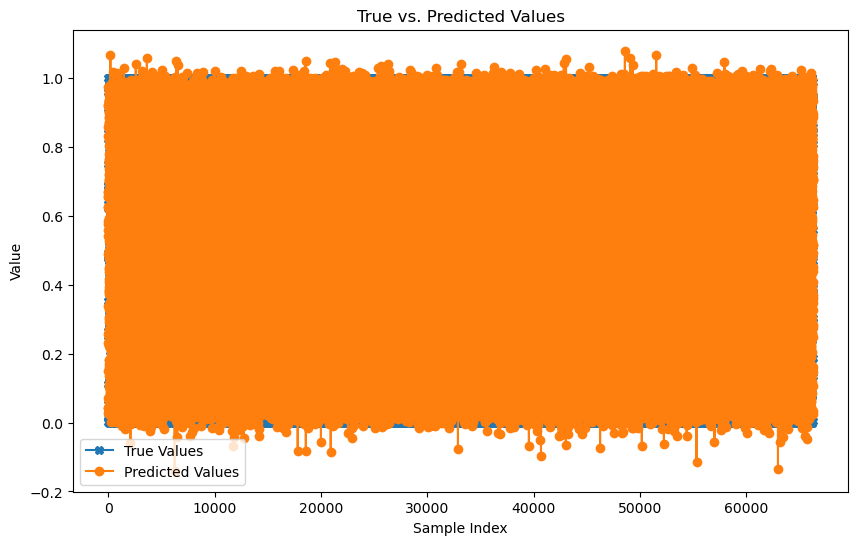

In [27]:
import matplotlib.pyplot as plt

# Check if the results from the model are available.
if results:
    # Initialise a new figure for plotting with dimensions 10x6 inches.
    plt.figure(figsize=(10, 6))
    
    # Plot the true values for the first feature across all samples in the test set,
    # marking each point with an 'X'.
    plt.plot(y_test_inverse[:, 0], label='True Values', marker='X')  # The first feature is selected with [:, 0].
    
    # Plot the predicted values for the same feature, using circles ('o') to mark each predicted point.
    plt.plot(predictions_inverse[:, 0], label='Predicted Values', marker='o')  # Likewise, focusing on the first feature.
    
    # Set the title of the plot to indicate it's comparing true values against predicted ones.
    plt.title('True vs. Predicted Values')
    
    # Label the x-axis as 'Sample Index' to indicate the position of each sample in the dataset.
    plt.xlabel('Sample Index')
    
    # Label the y-axis as 'Value' to denote the value of the feature being plotted.
    plt.ylabel('Value')
    
    # Add a legend to the plot to distinguish between true and predicted values visually.
    plt.legend()
    
    # Display the plot.
    plt.show()


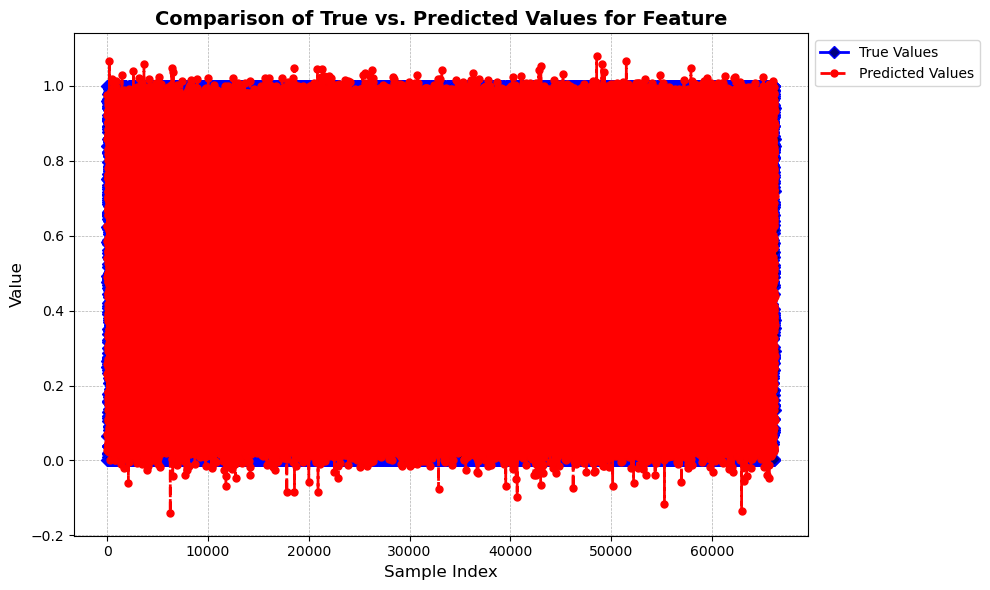

In [28]:
#Second Visualisation 

if results:
    # Initialise a figure for plotting with dimensions 10x6 inches for better visibility.
    plt.figure(figsize=(10, 6))
    
    # Plot the true values with a solid blue line and diamond markers.
    plt.plot(y_test_inverse[:, 0], 'b-',
             label='True Values', linewidth=2, marker='D', markersize=6, markerfacecolor='navy')
    
    # Plot the predicted values with a dashed orange line and circle markers.
    plt.plot(predictions_inverse[:, 0], 'r--',
             label='Predicted Values', linewidth=2, marker='o', markersize=5, markerfacecolor='red')
    
    # Set a more descriptive title to provide context.
    plt.title('Comparison of True vs. Predicted Values for Feature', fontsize=14, fontweight='bold')
    
    # Label axes with more detail.
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    
    # Add a grid to the background for better readability.
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add a legend with an optimal position outside the plot area.
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout to make room for the legend.
    plt.tight_layout()
    
    # Display the enhanced plot.
    plt.show()

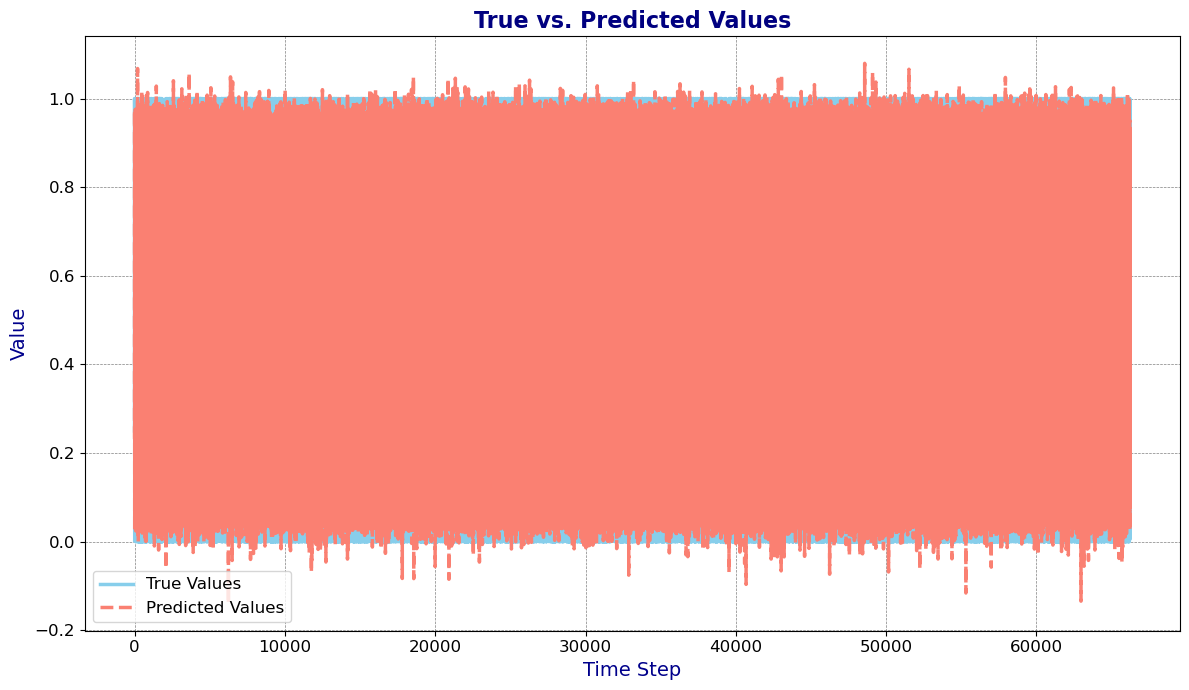

In [29]:
#Third Visualisation

if results:
    # Initialize the plot with a specific size for better visibility
    plt.figure(figsize=(12, 7))

    # Plot the true values using a solid line
    plt.plot(y_test_inverse[:, 0], label='True Values', color='skyblue', linewidth=2.5, linestyle='-')

    # Plot the predicted values using a different style
    plt.plot(predictions_inverse[:, 0], label='Predicted Values', color='salmon', linewidth=2.5, linestyle='--')

    # Adding some aesthetics to make the chart more readable and visually appealing
    plt.title('True vs. Predicted Values', fontsize=16, fontweight='bold', color='navy')
    plt.xlabel('Time Step', fontsize=14, color='darkblue')
    plt.ylabel('Value', fontsize=14, color='darkblue')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Enable grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
    
    # Add a legend to help differentiate between true and predicted values
    plt.legend(loc='best', fontsize=12)

    # Ensure everything fits without clipping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [38]:
print("Received data for insertion:", results)  # Debug print

Received data for insertion: {'X_test': array([[[1.00000000e+00, 7.14285714e-01, 1.00000000e+00, 1.00000000e+00,
         0.00000000e+00],
        [1.00000000e+00, 7.14285714e-01, 1.00000000e+00, 1.00000000e+00,
         0.00000000e+00],
        [1.00000000e+00, 4.28571429e-01, 6.00000000e-01, 1.00000000e+00,
         1.72784579e-02],
        ...,
        [2.50000000e-01, 2.85714286e-01, 4.00000000e-01, 1.42857143e-01,
         0.00000000e+00],
        [2.50000000e-01, 1.42857143e-01, 2.00000000e-01, 1.42857143e-01,
         9.54472635e-03],
        [2.50000000e-01, 1.42857143e-01, 2.00000000e-01, 1.42857143e-01,
         4.67985442e-04]],

       [[7.75510204e-01, 8.24468085e-01, 7.80104712e-01, 7.97979798e-01,
         1.55063760e-01],
        [8.52040816e-01, 8.45744681e-01, 7.95811518e-01, 7.77777778e-01,
         1.80271493e-01],
        [8.06122449e-01, 7.23404255e-01, 7.27748691e-01, 7.02020202e-01,
         1.50621144e-01],
        ...,
        [7.04081633e-01, 6.86170213e-01, 

In [72]:
'''
#second attemp
def insert_predictions(insert_data):
    table_name = "dimension.predictive_Model7_results"
    # Define the SQL insert statement
    insert_query_template = f"""
    INSERT INTO {table_name} (
        Symbol, True_Open, True_High, True_Low, True_Close, True_Volume,
        Predicted_Open, Predicted_High, Predicted_Low, Predicted_Close, Predicted_Volume,
        DateTo)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    """
    
    for row in insert_data:
        # Prepare the values for insertion
        values = (
            row["Symbol"],
            row["True_Open"], row["True_High"], row["True_Low"], row["True_Close"], row["True_Volume"],
            row["Predicted_Open"], row["Predicted_High"], row["Predicted_Low"], row["Predicted_Close"], row["Predicted_Volume"],
            row["DateTo"]
        )
        
        # Use the execute_sql_query function to insert the data
        execute_sql_query(insert_query_template, values)

'''
'''
first attempt
def insert_predictions(insert_data):
    #table_name = "dimension.predictive_Model7_results"
    # truncate_table_query = f"TRUNCATE TABLE {table_name};"
    
    # Define the SQL insert statement for only predicted values
    insert_model_data = f"""
    INSERT INTO {table_name} (
        Symbol, Predicted_Open, Predicted_High, Predicted_Low, Predicted_Close, Predicted_Volume, DateTo)
    VALUES (%s, %s, %s, %s, %s, %s, %s);
    """
    
    # Start a transaction block
    #execute_sql_query("BEGIN;")
    
    # Truncate the table to remove old data
    #execute_sql_query(truncate_table_query)
    
    # Insert new records
    for row in insert_data:
        # Prepare the values for insertion for predicted values only
        values = (
            row["Symbol"],
            row["Predicted_Open"], row["Predicted_High"], row["Predicted_Low"], row["Predicted_Close"], row["Predicted_Volume"],
            row["DateTo"]
        )
        
        # Use the execute_sql_query function to insert the data
        execute_sql_query(insert_model_data, values)
    
    # Commit the transaction to finalize the changes
    #execute_sql_query("COMMIT;")
'''


'\nfirst attempt\ndef insert_predictions(insert_data):\n    #table_name = "dimension.predictive_Model7_results"\n    # truncate_table_query = f"TRUNCATE TABLE {table_name};"\n    \n    # Define the SQL insert statement for only predicted values\n    insert_model_data = f"""\n    INSERT INTO {table_name} (\n        Symbol, Predicted_Open, Predicted_High, Predicted_Low, Predicted_Close, Predicted_Volume, DateTo)\n    VALUES (%s, %s, %s, %s, %s, %s, %s);\n    """\n    \n    # Start a transaction block\n    #execute_sql_query("BEGIN;")\n    \n    # Truncate the table to remove old data\n    #execute_sql_query(truncate_table_query)\n    \n    # Insert new records\n    for row in insert_data:\n        # Prepare the values for insertion for predicted values only\n        values = (\n            row["Symbol"],\n            row["Predicted_Open"], row["Predicted_High"], row["Predicted_Low"], row["Predicted_Close"], row["Predicted_Volume"],\n            row["DateTo"]\n        )\n        \n       

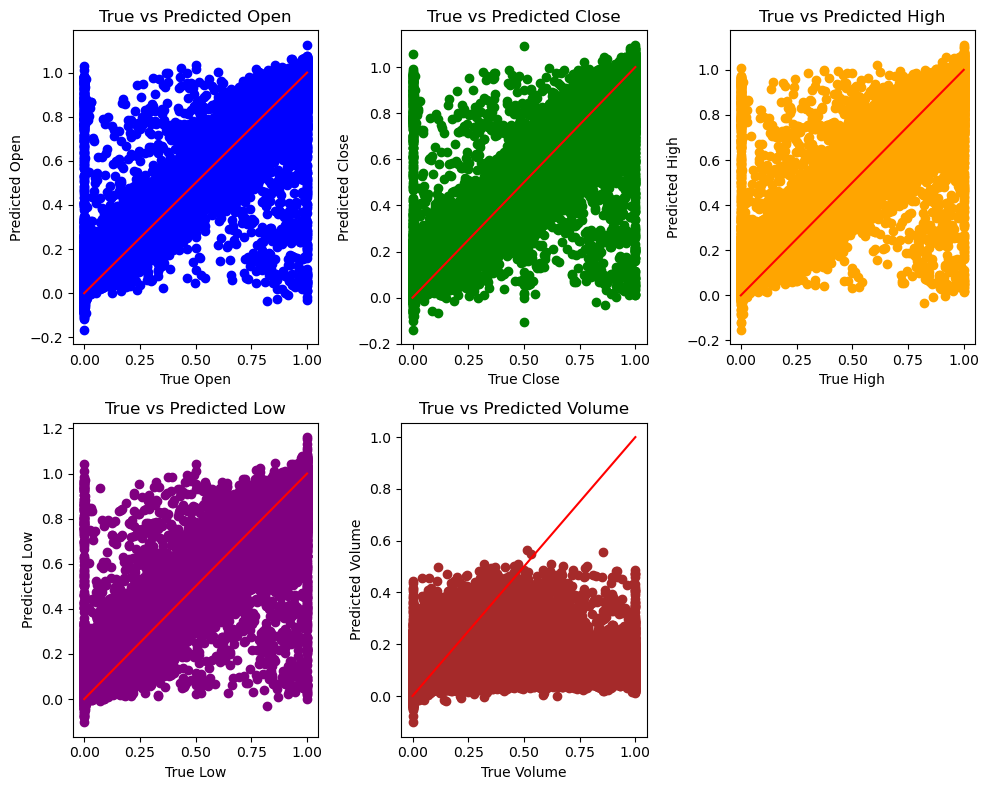

In [17]:
import matplotlib.pyplot as plt

# Extract true and predicted values from the results dictionary
true_open = results['y_test'][:, 0]
true_close = results['y_test'][:, 1]
true_high = results['y_test'][:, 2]
true_low = results['y_test'][:, 3]
true_volume = results['y_test'][:, 4]

predicted_open = results['predictions'][:, 0]
predicted_close = results['predictions'][:, 1]
predicted_high = results['predictions'][:, 2]
predicted_low = results['predictions'][:, 3]
predicted_volume = results['predictions'][:, 4]

# Plot True vs Predicted Open
plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 1)
plt.scatter(true_open, predicted_open, color='blue')
plt.plot([min(true_open), max(true_open)], [min(true_open), max(true_open)], color='red')
plt.xlabel('True Open')
plt.ylabel('Predicted Open')
plt.title('True vs Predicted Open')

# Plot True vs Predicted Close
plt.subplot(2, 3, 2)
plt.scatter(true_close, predicted_close, color='green')
plt.plot([min(true_close), max(true_close)], [min(true_close), max(true_close)], color='red')
plt.xlabel('True Close')
plt.ylabel('Predicted Close')
plt.title('True vs Predicted Close')

# Plot True vs Predicted High
plt.subplot(2, 3, 3)
plt.scatter(true_high, predicted_high, color='orange')
plt.plot([min(true_high), max(true_high)], [min(true_high), max(true_high)], color='red')
plt.xlabel('True High')
plt.ylabel('Predicted High')
plt.title('True vs Predicted High')

# Plot True vs Predicted Low
plt.subplot(2, 3, 4)
plt.scatter(true_low, predicted_low, color='purple')
plt.plot([min(true_low), max(true_low)], [min(true_low), max(true_low)], color='red')
plt.xlabel('True Low')
plt.ylabel('Predicted Low')
plt.title('True vs Predicted Low')

# Plot True vs Predicted Volume
plt.subplot(2, 3, 5)
plt.scatter(true_volume, predicted_volume, color='brown')
plt.plot([min(true_volume), max(true_volume)], [min(true_volume), max(true_volume)], color='red')
plt.xlabel('True Volume')
plt.ylabel('Predicted Volume')
plt.title('True vs Predicted Volume')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [51]:
if results:
    # Update the 'predictions' key in the results dictionary with model predictions on the test set.
    results['predictions'] = results['model'].predict(results['X_test'])
    
    # Apply inverse transformation back to their original scale.
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    
    # Prepare the data for "insertion" (test print in this case) based on predicted values.
    insert_data_test = []
    for i in range(len(predictions_inverse)):
        row = {
            "Symbol": results['test_symbols'][i],
            "Predicted_Open": round(float(predictions_inverse[i, 5]), 2),
            "Predicted_High": round(float(predictions_inverse[i, 6]), 2),
            "Predicted_Low": round(float(predictions_inverse[i, 7]), 2),
            "Predicted_Close": round(float(predictions_inverse[i, 8]), 2),
            "Predicted_Volume": round(float(predictions_inverse[i, 9]), 2),
        }
        insert_data_test.append(row)

    # Instead of inserting, print the prepared data to visually inspect
    print("Prepared data for insertion (test):")
    for item in insert_data_test[:20]:  # Print first 20 entries for brevity
        print(item)

        '''row["Symbol"],
            row["True_Open"], row["True_High"], row["True_Low"], row["True_Close"], row["True_Volume"],
            row["Predicted_Open"], row["Predicted_High"], row["Predicted_Low"], row["Predicted_Close"], row["Predicted_Volume"],
            row["DateTo"]'''

2070/2070 [==============================] - 11s 5ms/step


IndexError: index 5 is out of bounds for axis 1 with size 5

In [73]:
import pandas as pd

# Assuming predictions_inverse, y_test_inverse, and test_symbols are available from your results
data = {
    "Symbol": test_symbols,
    "Predicted_Open": predictions_inverse[:, 0],
    "Predicted_High": predictions_inverse[:, 1],
    "Predicted_Low": predictions_inverse[:, 2],
    "Predicted_Close": predictions_inverse[:, 3],
    "Predicted_Volume": predictions_inverse[:, 4],
    # Include true values if needed, for comparison or further processing
    "True_Open": y_test_inverse[:, 0],
    "True_High": y_test_inverse[:, 1],
    "True_Low": y_test_inverse[:, 2],
    "True_Close": y_test_inverse[:, 3],
    "True_Volume": y_test_inverse[:, 4]
}

# Create a DataFrame
df_predictions = pd.DataFrame(data)

# Round the predictions for a cleaner look or if necessary for your database schema
df_predictions = df_predictions.round(2)

print(df_predictions.head(10))


   Symbol  Predicted_Open  Predicted_High  Predicted_Low  Predicted_Close  \
0   ACC.L            0.23            0.17           0.21       179.220001   
1  0MKT.L            0.63            0.64           0.64       179.699997   
2   NTN.L            0.97            0.98           0.98       180.070007   
3  0I77.L            0.54            0.53           0.55       179.610001   
4  LCAS.L            0.59            0.59           0.58       179.669998   
5  LSUG.L            0.86            0.87           0.87       179.949997   
6  KLWD.L            0.63            0.38           0.37       179.490005   
7   GUS.L            0.92            0.92           0.93       179.779999   
8  XSFR.L            0.26            0.26           0.29       179.339996   
9  IPRP.L            0.49            0.50           0.47       179.580002   

   Predicted_Volume  True_Open  True_High  True_Low  True_Close  True_Volume  
0       7500.049805       0.25       0.29      0.40      179.23      7500

In [55]:
import pandas as pd

# Convert arrays to DataFrames and assign column names
predictions_df = pd.DataFrame(predictions_inverse, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
y_test_df = pd.DataFrame(y_test_inverse, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Now you can easily print predictions vs. true values with field names
print("Predictions vs. True Values:")
for i in range(10):  # Adjust the range as needed
    print(f"Prediction {i+1}: {predictions_df.iloc[i].to_dict()}, True Value {i+1}: {y_test_df.iloc[i].to_dict()}")


Predictions vs. True Values:
Prediction 1: {'Open': 0.23142793774604797, 'High': 0.16800057888031006, 'Low': 0.207370787858963, 'Close': 179.2152862548828, 'Volume': 7500.05126953125}, True Value 1: {'Open': 0.25, 'High': 0.2857142857142856, 'Low': 0.3999999999999986, 'Close': 179.23285714285714, 'Volume': 7500.0}
Prediction 2: {'Open': 0.62709641456604, 'High': 0.6356577277183533, 'Low': 0.643252968788147, 'Close': 179.6955108642578, 'Volume': 7500.21826171875}, True Value 2: {'Open': 0.6224489795918369, 'High': 0.6436170212765964, 'Low': 0.6858638743455496, 'Close': 179.72131313131314, 'Volume': 7500.094364459071}
Prediction 3: {'Open': 0.9747039079666138, 'High': 0.9809756875038147, 'Low': 0.9790716171264648, 'Close': 180.0667266845703, 'Volume': 7500.01904296875}, True Value 3: {'Open': 1.0000000000000002, 'High': 1.0000000000000002, 'Low': 1.0000000000000002, 'Close': 180.09, 'Volume': 7500.0}
Prediction 4: {'Open': 0.5407073497772217, 'High': 0.5323891043663025, 'Low': 0.54558062

In [59]:
if results:
    # Inverse transform the predictions and true values to their original scale
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    #y_test_inverse = results['scaler'].inverse_transform(results['y_test'])
    #test_symbols = results['test_symbols']  # Ensure this exists and corresponds to the correct symbols

    # Print the first few predictions vs. true values for comparison, including the symbol
    #print("Predictions vs. True Values:")
    for i in range(10):  # Adjust the range as needed
        print(f"Symbol {i+1}: {test_symbols[i]}, Prediction {i+1}: {predictions_inverse[i]}, True Value {i+1}: {y_test_inverse[i]}")

Symbol 1: ACC.L, Prediction 1: [2.3142794e-01 1.6800058e-01 2.0737079e-01 1.7921529e+02 7.5000513e+03], True Value 1: [2.50000000e-01 2.85714286e-01 4.00000000e-01 1.79232857e+02
 7.50000000e+03]
Symbol 2: 0MKT.L, Prediction 2: [6.2709641e-01 6.3565773e-01 6.4325297e-01 1.7969551e+02 7.5002183e+03], True Value 2: [6.22448980e-01 6.43617021e-01 6.85863874e-01 1.79721313e+02
 7.50009436e+03]
Symbol 3: NTN.L, Prediction 3: [9.7470391e-01 9.8097569e-01 9.7907162e-01 1.8006673e+02 7.5000190e+03], True Value 3: [1.0000e+00 1.0000e+00 1.0000e+00 1.8009e+02 7.5000e+03]
Symbol 4: 0I77.L, Prediction 4: [5.4070735e-01 5.3238910e-01 5.4558063e-01 1.7960999e+02 7.5000215e+03], True Value 4: [4.77517241e-01 4.62886880e-01 4.67805151e-01 1.79548017e+02
 7.50000323e+03]
Symbol 5: LCAS.L, Prediction 5: [5.863123e-01 5.875447e-01 5.809313e-01 1.796717e+02 7.500037e+03], True Value 5: [5.82781457e-01 5.82781457e-01 5.82781457e-01 1.79672781e+02
 7.50000000e+03]
Symbol 6: LSUG.L, Prediction 6: [8.5825831e

In [86]:
def prepare_and_insert_predictions(results):
    # Update the 'predictions' key with model predictions on the test set
    results['predictions'] = results['model'].predict(results['X_test'])
    
    # Inverse transform the predictions to their original scale
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    print(predictions_inverse)
    # Define your SQL insert statement (excluding the DateTo column as you mentioned)
    table_name = "dimension.predictive_Model7_results"
    insert_query_template = f"""
    INSERT INTO {table_name} (
        Symbol, Predicted_Open, Predicted_High, Predicted_Low, Predicted_Close, Predicted_Volume)
    VALUES (%s, %s, %s, %s, %s, %s);
    """
    
    # Prepare the data for insertion based on predicted values
    for i in range(len(predictions_inverse)):
        values = (
            results['test_symbols'][i],              # Symbol for the prediction
            round(float(predictions_inverse[i, 0]), 2),  # Predicted open value
            round(float(predictions_inverse[i, 1]), 2),  # Predicted high value
            round(float(predictions_inverse[i, 2]), 2),  # Predicted low value
            round(float(predictions_inverse[i, 3]), 2),  # Predicted close value
            round(float(predictions_inverse[i, 4]), 2),  # Predicted volume
        )
        
        # Execute the SQL query to insert the data
        execute_sql_query(insert_query_template, values)

# Assuming results dictionary is prepared with your model, scaler, test symbols, and test data
#prepare_and_insert_predictions(results)
print(prepare_and_insert_predictions)

<function prepare_and_insert_predictions at 0x28aa02f20>


In [85]:
import pandas as pd

# Example assuming 'predictions' are obtained and inverse transformed
predictions_inverse = results['scaler'].inverse_transform(results['predictions'])

# Convert the predictions into a DataFrame, naming columns for clarity
predictions_df = pd.DataFrame(predictions_inverse, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
predictions_df['Symbol'] = results['test_symbols']
print(predictions_df)

           Open      High       Low       Close       Volume  Symbol
0      0.231428  0.168001  0.207371  179.215286  7500.051270   ACC.L
1      0.627096  0.635658  0.643253  179.695511  7500.218262  0MKT.L
2      0.974704  0.980976  0.979072  180.066727  7500.019043   NTN.L
3      0.540707  0.532389  0.545581  179.609985  7500.021484  0I77.L
4      0.586312  0.587545  0.580931  179.671707  7500.037109  LCAS.L
...         ...       ...       ...         ...          ...     ...
66234  0.278545  0.267101  0.296374  179.377838  7500.274902  0OLD.L
66235  0.896935  0.902204  0.923777  179.998413  7500.095703  0O0V.L
66236  0.932364  0.950092  0.951741  179.535873  7500.064941  SGBS.L
66237  0.706803  0.705320  0.702602  179.802383  7500.034180  PQVM.L
66238  0.758736  0.756123  0.766119  179.856400  7500.035645  EGRW.L

[66239 rows x 6 columns]
